#Required Packages

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import log_loss, matthews_corrcoef
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import LSTM

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#Load the Dataset

In [6]:
df = pd.read_csv("imdbdataset.csv")
print(df.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


#Preprocessing of Data

##Lowercasing

In [7]:
df['review'] = df['review'].str.lower()
print(df.head())

                                              review sentiment
0  one of the other reviewers has mentioned that ...  positive
1  a wonderful little production. <br /><br />the...  positive
2  i thought this was a wonderful way to spend ti...  positive
3  basically there's a family where a little boy ...  negative
4  petter mattei's "love in the time of money" is...  positive


##Removing HTML Tags

In [8]:
def remove_html_tags(text):
    pattern = re.compile('<[^<]+?>')
    return pattern.sub(r'', text)

df['review'] = df['review'].apply(remove_html_tags)

print(df.head())

                                              review sentiment
0  one of the other reviewers has mentioned that ...  positive
1  a wonderful little production. the filming tec...  positive
2  i thought this was a wonderful way to spend ti...  positive
3  basically there's a family where a little boy ...  negative
4  petter mattei's "love in the time of money" is...  positive


##Removing Punctuation marks

In [9]:
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

df['review'] = df['review'].apply(remove_punctuation)

print(df.head())

                                              review sentiment
0  one of the other reviewers has mentioned that ...  positive
1  a wonderful little production the filming tech...  positive
2  i thought this was a wonderful way to spend ti...  positive
3  basically theres a family where a little boy j...  negative
4  petter matteis love in the time of money is a ...  positive


##Removing URL's

In [10]:
def remove_url(text):
    return re.sub(r'http[s]?://\S+|www\.\S+', '', text)

df['review'] = df['review'].apply(remove_url)

##Removing extra white spaces

In [11]:
def remove_extra_whitespaces(text):
    return re.sub(' +', ' ', text).strip()

df['review'] = df['review'].apply(remove_extra_whitespaces)

print(df.head())

                                              review sentiment
0  one of the other reviewers has mentioned that ...  positive
1  a wonderful little production the filming tech...  positive
2  i thought this was a wonderful way to spend ti...  positive
3  basically theres a family where a little boy j...  negative
4  petter matteis love in the time of money is a ...  positive


##Removing stop words

In [12]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    lst = []
    for word in text.split():
        if word not in stop_words:
            lst.append(word)
    return " ".join(lst)

print(df['review'][1])

df['review'] = df['review'].apply(remove_stopwords)

print(df['review'][1])

print(df.head())

a wonderful little production the filming technique is very unassuming very oldtimebbc fashion and gives a comforting and sometimes discomforting sense of realism to the entire piece the actors are extremely well chosen michael sheen not only has got all the polari but he has all the voices down pat too you can truly see the seamless editing guided by the references to williams diary entries not only is it well worth the watching but it is a terrificly written and performed piece a masterful production about one of the great masters of comedy and his life the realism really comes home with the little things the fantasy of the guard which rather than use the traditional dream techniques remains solid then disappears it plays on our knowledge and our senses particularly with the scenes concerning orton and halliwell and the sets particularly of their flat with halliwells murals decorating every surface are terribly well done
wonderful little production filming technique unassuming oldtim

##Removing Numbers

In [13]:
def remove_numbers(text):
    lst = []
    for word in text.split():
      if not word.isdigit():
        lst.append(word)
    return " ".join(lst)

df['review'] = df['review'].apply(remove_numbers)

print(df.head())

                                              review sentiment
0  one reviewers mentioned watching oz episode yo...  positive
1  wonderful little production filming technique ...  positive
2  thought wonderful way spend time hot summer we...  positive
3  basically theres family little boy jake thinks...  negative
4  petter matteis love time money visually stunni...  positive


##Word Tokenization

In [14]:
def tokenize(text):
    return word_tokenize(text)

df['review'] = df['review'].apply(tokenize)

print(df.head())

print(df.review[1])

                                              review sentiment
0  [one, reviewers, mentioned, watching, oz, epis...  positive
1  [wonderful, little, production, filming, techn...  positive
2  [thought, wonderful, way, spend, time, hot, su...  positive
3  [basically, theres, family, little, boy, jake,...  negative
4  [petter, matteis, love, time, money, visually,...  positive
['wonderful', 'little', 'production', 'filming', 'technique', 'unassuming', 'oldtimebbc', 'fashion', 'gives', 'comforting', 'sometimes', 'discomforting', 'sense', 'realism', 'entire', 'piece', 'actors', 'extremely', 'well', 'chosen', 'michael', 'sheen', 'got', 'polari', 'voices', 'pat', 'truly', 'see', 'seamless', 'editing', 'guided', 'references', 'williams', 'diary', 'entries', 'well', 'worth', 'watching', 'terrificly', 'written', 'performed', 'piece', 'masterful', 'production', 'one', 'great', 'masters', 'comedy', 'life', 'realism', 'really', 'comes', 'home', 'little', 'things', 'fantasy', 'guard', 'rather', 'us

##Word Lemmatization

In [15]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(word) for word in text]

df['review'] = df['review'].apply(lemmatize_text)

print(df.head())

print(df.review[1])

                                              review sentiment
0  [one, reviewer, mentioned, watching, oz, episo...  positive
1  [wonderful, little, production, filming, techn...  positive
2  [thought, wonderful, way, spend, time, hot, su...  positive
3  [basically, there, family, little, boy, jake, ...  negative
4  [petter, matteis, love, time, money, visually,...  positive
['wonderful', 'little', 'production', 'filming', 'technique', 'unassuming', 'oldtimebbc', 'fashion', 'give', 'comforting', 'sometimes', 'discomforting', 'sense', 'realism', 'entire', 'piece', 'actor', 'extremely', 'well', 'chosen', 'michael', 'sheen', 'got', 'polari', 'voice', 'pat', 'truly', 'see', 'seamless', 'editing', 'guided', 'reference', 'williams', 'diary', 'entry', 'well', 'worth', 'watching', 'terrificly', 'written', 'performed', 'piece', 'masterful', 'production', 'one', 'great', 'master', 'comedy', 'life', 'realism', 'really', 'come', 'home', 'little', 'thing', 'fantasy', 'guard', 'rather', 'use', 'trad

##Convert sentiment to Numeric values

In [16]:
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

print(df.head())

                                              review  sentiment
0  [one, reviewer, mentioned, watching, oz, episo...          1
1  [wonderful, little, production, filming, techn...          1
2  [thought, wonderful, way, spend, time, hot, su...          1
3  [basically, there, family, little, boy, jake, ...          0
4  [petter, matteis, love, time, money, visually,...          1


#Split the dataset into Train, Test and Validation Data

In [17]:
X = df['review'].apply(lambda x: ' '.join(x))
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Train set:", len(X_train))
print("Validation set:", len(X_val))
print("Test set:", len(X_test))

Train set: 32000
Validation set: 8000
Test set: 10000


#Implementation of Machine Learning Algorithms

##Logistic Regression

###Implementation and Training

In [ ]:
param_grid = {
    'tfidf__max_features': [1000, 5000, 10000],
    'lr__C': [0.1, 1.0, 10.0]
}

In [ ]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

In [ ]:
grid_search_lr = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=2)

In [ ]:
grid_search_lr.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'lr__C': [0.1, 1.0, 10.0],
                         'tfidf__max_features': [1000, 5000, 10000]},
             verbose=2)

In [ ]:
best_hyper_params = grid_search_lr.best_params_
best_lr_model = grid_search_lr.best_estimator_
best_lr_model.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=10000)),
                ('lr', LogisticRegression())])

###Performance Metrics

In [ ]:
val_accuracy_lr = best_lr_model.score(X_val, y_val)
test_accuracy_lr = best_lr_model.score(X_test, y_test)
y_pred_lr = best_lr_model.predict(X_test)
y_pred_proba_lr = best_lr_model.predict_proba(X_test)
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
class_report_lr = classification_report(y_test, y_pred_lr)
logloss_lr = log_loss(y_test, y_pred_proba_lr)
mcc_lr = matthews_corrcoef(y_test, y_pred_lr)

In [ ]:
print("Best Training Parameters:", best_hyper_params)
print("Best Training Accuracy:", grid_search_lr.best_score_)
print("Validation Accuracy of LR:", val_accuracy_lr)
print("Test Accuracy of LR:", test_accuracy_lr)
print("Log Loss of LR:", logloss_lr)
print("Matthews Correlation Coefficient of LR:", mcc_lr)

Best Training Parameters: {'lr__C': 1.0, 'tfidf__max_features': 10000}
Best Training Accuracy: 0.8833123669554368
Validation Accuracy of LR: 0.88925
Test Accuracy of LR: 0.8899
Log Loss of LR: 0.29401710596401565
Matthews Correlation Coefficient of LR: 0.7799735637550034


In [ ]:
print("Classification Report of LR:")
print(class_report_lr)

Classification Report of LR:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



###Performance representations and Curves

####Confusion Matrix

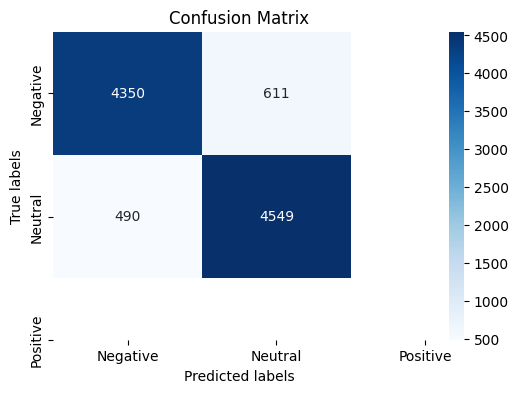

In [ ]:
def plot_confusion_matrix(conf_matrix, labels):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(conf_matrix_lr, ['Negative', 'Neutral', 'Positive'])

####Precision-Recall Curve

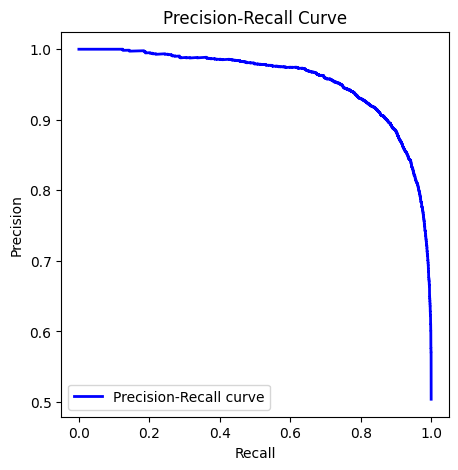

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_lr[:,1], pos_label=1)
plt.figure(figsize=(5, 5))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

####ROC Curve

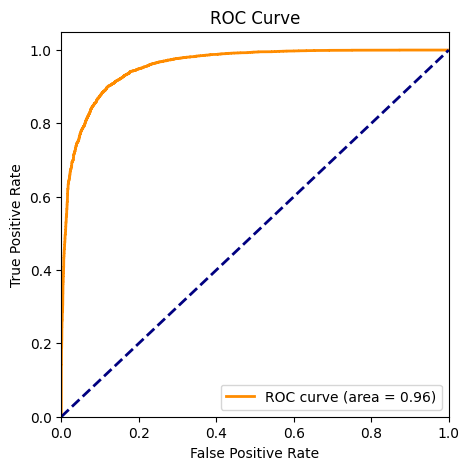

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_lr[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

####Learning Curve

In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(best_lr_model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=3)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

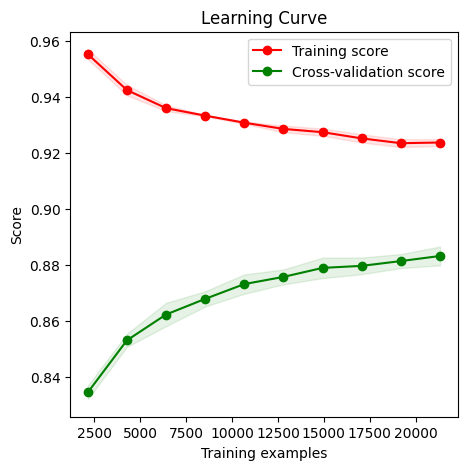

In [ ]:
plt.figure(figsize=(5, 5))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()

####Validation Curve

In [ ]:
param_range = [1000, 5000, 10000, 0.1, 1.0, 10.0]
train_scores, valid_scores = validation_curve(best_lr_model, X_train, y_train, param_name="tfidf__max_features", param_range=param_range, cv=3)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

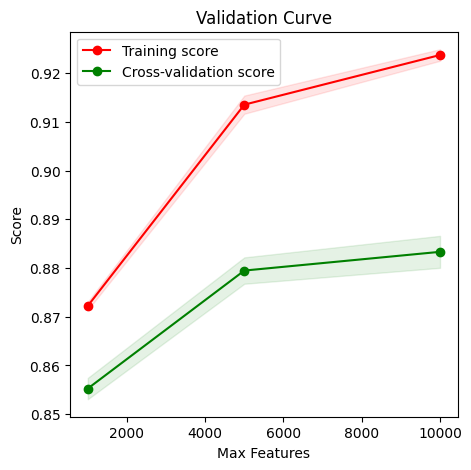

In [ ]:
plt.figure(figsize=(5, 5))
plt.plot(param_range, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(param_range, valid_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(param_range, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
plt.xlabel("Max Features")
plt.ylabel("Score")
plt.title("Validation Curve")
plt.legend(loc="best")
plt.show()

##Naive Bayes Classifier

###Implementation and Training

In [ ]:
param_grid = {
    'tfidf__max_features': [1000, 5000, 10000],
    'nb__alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
    'nb__fit_prior': [True, False]
}

In [ ]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [ ]:
grid_search_nb = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

In [ ]:
grid_search_nb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'nb__alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                         'nb__fit_prior': [True, False],
                         'tfidf__max_features': [1000, 5000, 10000]},
             scoring='accuracy')

In [ ]:
best_hyper_params = grid_search_nb.best_params_
best_nb_model = grid_search_nb.best_estimator_
best_nb_model.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=10000)),
                ('nb', MultinomialNB(alpha=2.0))])

###Performance Metrics

In [ ]:
val_accuracy_nb = best_nb_model.score(X_val, y_val)
test_accuracy_nb = best_nb_model.score(X_test, y_test)
y_pred_nb = best_nb_model.predict(X_test)
y_pred_proba_nb = best_nb_model.predict_proba(X_test)
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)
class_report_nb = classification_report(y_test, y_pred_nb)
logloss_nb = log_loss(y_test, y_pred_proba_nb)
mcc_nb = matthews_corrcoef(y_test, y_pred_nb)

In [ ]:
print("Best Training Parameters:", best_hyper_params)
print("Best Training Accuracy:", grid_search_nb.best_score_)
print("Validation Accuracy of NaiveBayes:", val_accuracy_nb)
print("Test Accuracy of NaiveBayes:", test_accuracy_nb)
print("Log Loss of NaiveBayes:", logloss_nb)
print("Matthews Correlation Coefficient of NaiveBayes:", mcc_nb)

Best Training Parameters: {'nb__alpha': 2.0, 'nb__fit_prior': True, 'tfidf__max_features': 10000}
Best Training Accuracy: 0.8543749999999999
Validation Accuracy of NaiveBayes: 0.861375
Test Accuracy of NaiveBayes: 0.8532
Log Loss of NaiveBayes: 0.41297945553582177
Matthews Correlation Coefficient of NaiveBayes: 0.7065092048530963


In [ ]:
print("Classification Report of NaiveBayes:")
print(class_report_nb)

Classification Report of NaiveBayes:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      4961
           1       0.86      0.85      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



###Performance representations and Curves

####Confusion Matrix

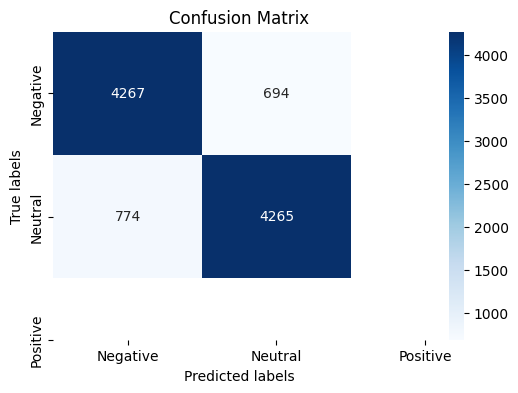

In [ ]:
def plot_confusion_matrix(conf_matrix, labels):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(conf_matrix_nb, ['Negative', 'Neutral', 'Positive'])

####Precision-Recall Curve

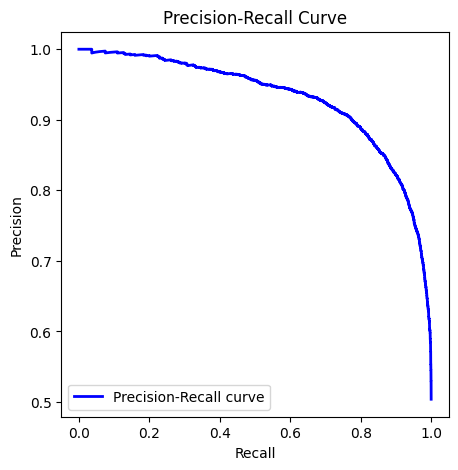

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_nb[:,1], pos_label=1)
plt.figure(figsize=(5, 5))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

####ROC Curve

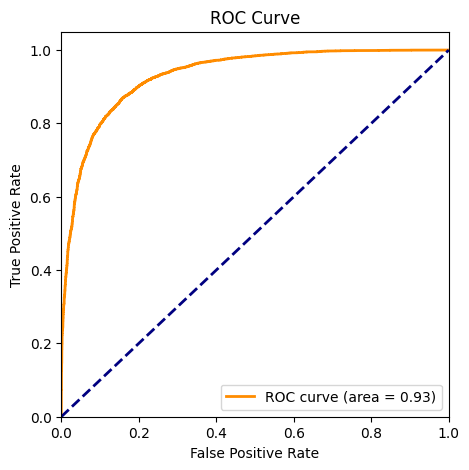

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_nb[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

####Learning Curve

In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(best_nb_model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=3)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

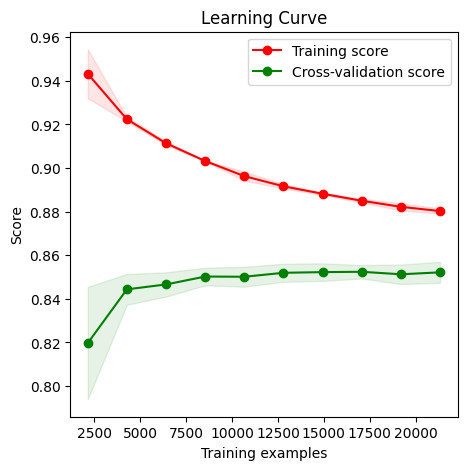

In [ ]:
plt.figure(figsize=(5, 5))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()

####Validation Curve

In [ ]:
param_range = [1000, 5000, 10000, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
train_scores, valid_scores = validation_curve(best_nb_model, X_train, y_train, param_name="tfidf__max_features", param_range=param_range, cv=3)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

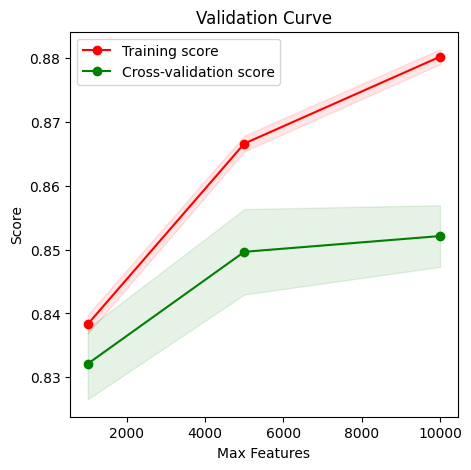

In [ ]:
plt.figure(figsize=(5, 5))
plt.plot(param_range, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(param_range, valid_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(param_range, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
plt.xlabel("Max Features")
plt.ylabel("Score")
plt.title("Validation Curve")
plt.legend(loc="best")
plt.show()

##Random Forest Classifier

###Implementation and Training

In [ ]:
param_grid = {
    'tfidf__max_features': [1000, 5000, 10000],
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [10, 20, 30]
}

In [ ]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

In [ ]:
grid_search_rf = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=2)

In [ ]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

In [ ]:
grid_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [10, 20, 30],
                         'rf__n_estimators': [100, 200, 300],
                         'tfidf__max_features': [1000, 5000, 10000]},
             verbose=2)

In [ ]:
best_hyper_params = grid_search_rf.best_params_
best_rf_model = grid_search_rf.best_estimator_
best_rf_model.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=10000)),
                ('rf', RandomForestClassifier(max_depth=30, n_estimators=200))])

###Performance Metrics

In [ ]:
val_accuracy_rf = best_rf_model.score(X_val, y_val)
test_accuracy_rf = best_rf_model.score(X_test, y_test)
y_pred_rf = best_rf_model.predict(X_test)
y_pred_proba_rf = best_rf_model.predict_proba(X_test)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf)
logloss_rf = log_loss(y_test, y_pred_proba_rf)
mcc_rf = matthews_corrcoef(y_test, y_pred_rf)

In [ ]:
print("Best Training Parameters:", best_hyper_params)
print("Best Training Accuracy:", grid_search_rf.best_score_)
print("Validation Accuracy of RandomForest:", val_accuracy_rf)
print("Test Accuracy of RandomForest:", test_accuracy_rf)
print("Log Loss of RandomForest:", logloss_rf)
print("Matthews Correlation Coefficient of RandomForest:", mcc_rf)

Best Training Parameters: {'rf__max_depth': 30, 'rf__n_estimators': 200, 'tfidf__max_features': 10000}
Best Training Accuracy: 0.8434686022287193
Validation Accuracy of RandomForest: 0.8515
Test Accuracy of RandomForest: 0.8487
Log Loss of RandomForest: 0.5052914308747806
Matthews Correlation Coefficient of RandomForest: 0.6977446333249044


In [ ]:
print("Classification Report of RandomForest:")
print(class_report_rf)

Classification Report of RandomForest:
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      4961
           1       0.84      0.87      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



###Performance representations and Curves

####Confusion Matrix

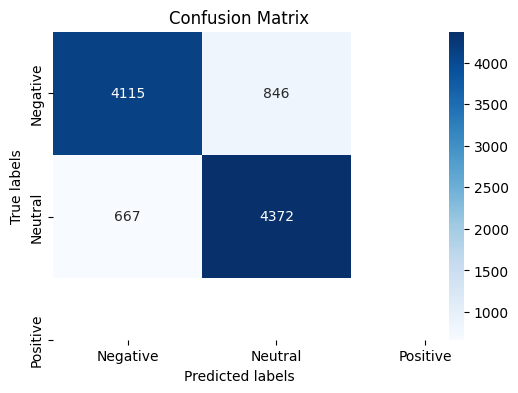

In [ ]:
def plot_confusion_matrix(conf_matrix, labels):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(conf_matrix_rf, ['Negative', 'Neutral', 'Positive'])

####Precision-Recall Curve

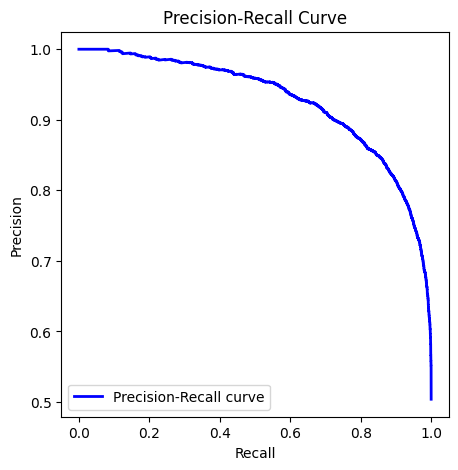

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_rf[:,1], pos_label=1)
plt.figure(figsize=(5, 5))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

####ROC Curve

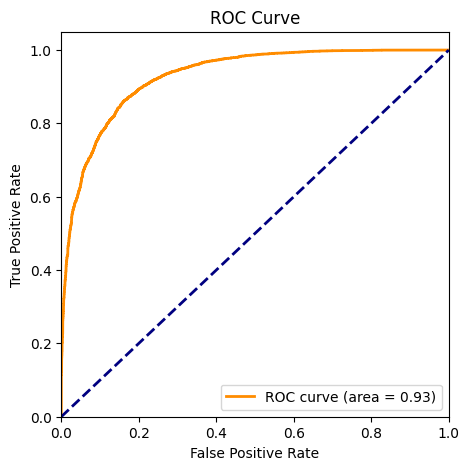

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_rf[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

####Learning Curve

In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(best_rf_model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=3)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

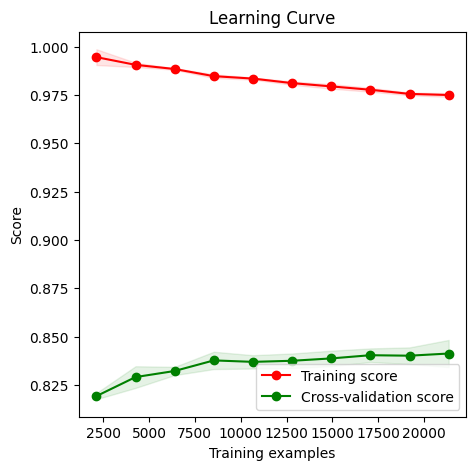

In [ ]:
plt.figure(figsize=(5, 5))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()

####Validation Curve

In [ ]:
param_range = [1000, 5000, 10000, 100, 200, 300, 10, 20, 30]
train_scores, valid_scores = validation_curve(best_rf_model, X_train, y_train, param_name="tfidf__max_features", param_range=param_range, cv=3)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

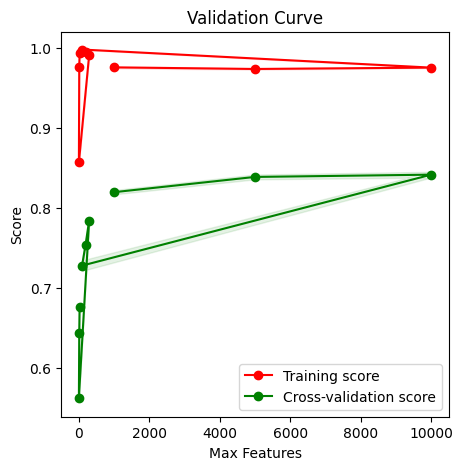

In [ ]:
plt.figure(figsize=(5, 5))
plt.plot(param_range, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(param_range, valid_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(param_range, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
plt.xlabel("Max Features")
plt.ylabel("Score")
plt.title("Validation Curve")
plt.legend(loc="best")
plt.show()

#Creating an embedding layer for the first layer of Neural Network

In [18]:
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)

In [19]:
maxlen = 100
X_train_pad = pad_sequences(sequences, maxlen=maxlen)
X_val_pad = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=maxlen)
X_test_pad = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=maxlen)
word_index = tokenizer.word_index
reverse_word_index = {v: k for k, v in word_index.items()}

In [20]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        if word in word_index and word_index[word] < max_words:
            embedding_matrix[word_index[word]] = np.array(values[1:], dtype='float32')

#Neural Network Algorithms

##Simple Neural Network

###Implementation and Training

In [56]:
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4]
}

In [57]:
def create_model(embedding_matrix, maxlen, embedding_dim=100, max_words=10000, dropout_rate=0.2):
    model = Sequential()
    model.add(Embedding(embedding_matrix.shape[0],
                        embedding_matrix.shape[1],
                        input_length=maxlen,
                        weights=[embedding_matrix],
                        trainable=False))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [76]:
best_val_acc_nn = 0
best_model_nn = None
best_hyperparams = None
best_model_nn_history = None

In [77]:
train_scores = []
val_scores = []

In [78]:
for dropout_rate in param_grid['dropout_rate']:
    model = create_model(embedding_matrix=embedding_matrix, maxlen=maxlen, embedding_dim=embedding_dim, max_words=max_words, dropout_rate=dropout_rate)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)
    history = model.fit(X_train_pad, y_train, epochs=10, batch_size=32, verbose=1,
              validation_data=(X_val_pad, y_val), callbacks=[early_stopping])
    val_loss, val_acc = model.evaluate(X_val_pad, y_val)
    train_acc = history.history['accuracy'][-1]
    train_scores.append(train_acc)
    val_scores.append(val_acc)
    if val_acc > best_val_acc_nn:
        best_val_acc_nn = val_acc
        best_model_nn = model
        best_model_nn_history = history
        best_hyperparams = {'dropout_rate': dropout_rate}

Epoch 1/10
1000/1000 [==============================] - 12s 8ms/step - loss: 0.5525 - accuracy: 0.7181 - val_loss: 0.4986 - val_accuracy: 0.7516
Epoch 2/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.4453 - accuracy: 0.7932 - val_loss: 0.4828 - val_accuracy: 0.7666
Epoch 3/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.3834 - accuracy: 0.8248 - val_loss: 0.5262 - val_accuracy: 0.7676
Epoch 4/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3298 - accuracy: 0.8510 - val_loss: 0.5250 - val_accuracy: 0.7674
Epoch 5/10
250/250 [==============================] - 1s 3ms/step - loss: 0.5861 - accuracy: 0.7588
Epoch 1/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.5643 - accuracy: 0.7096 - val_loss: 0.5386 - val_accuracy: 0.7128
Epoch 2/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.4528 - accuracy: 0.7870 - val_loss: 0.4841 - val_accuracy: 0.7720
Epoch 3/10
1000/1000 [=============

###Performance Metrics

In [79]:
test_loss_nn, test_acc_nn = best_model_nn.evaluate(X_test_pad, y_test)
y_pred_proba_nn = best_model_nn.predict(X_test_pad)
y_pred_nn = (y_pred_proba_nn > 0.5).astype("int32")
conf_matrix_nn = confusion_matrix(y_test, y_pred_nn)
class_report_nn = classification_report(y_test, y_pred_nn)
logloss_nn = log_loss(y_test, y_pred_proba_nn)
mcc_nn = matthews_corrcoef(y_test, y_pred_nn)

313/313 [==============================] - 1s 3ms/step


In [80]:
print("Best Hyperparameters of NN:", best_hyperparams)
print("Best Training Accuracy:", best_val_acc_nn)
print("Testing Accuracy with best model:", test_acc_nn)
print("Log Loss of Neural Network:", logloss_nn)
print("Matthews Correlation Coefficient of Neural Network:", mcc_nn)
print("Best Neural Network model Summary:")
print(best_model_nn.summary())

Best Hyperparameters of NN: {'dropout_rate': 0.4}
Best Training Accuracy: 0.7628750205039978
Testing Accuracy with best model: 0.7573000192642212
Log Loss of Neural Network: 0.5184450613897512
Matthews Correlation Coefficient of Neural Network: 0.5156443463530335
Best Neural Network model Summary:
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 100, 100)          1000000   
                                                                 
 flatten_8 (Flatten)         (None, 10000)             0         
                                                                 
 dense_26 (Dense)            (None, 32)                320032    
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_27 (Dense) 

In [81]:
print("Classification Report of Neural Network:")
print(class_report_nn)

Classification Report of Neural Network:
              precision    recall  f1-score   support

           0       0.78      0.72      0.75      4961
           1       0.74      0.79      0.77      5039

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



###Performance representations and Curves

####Confusion Matrix

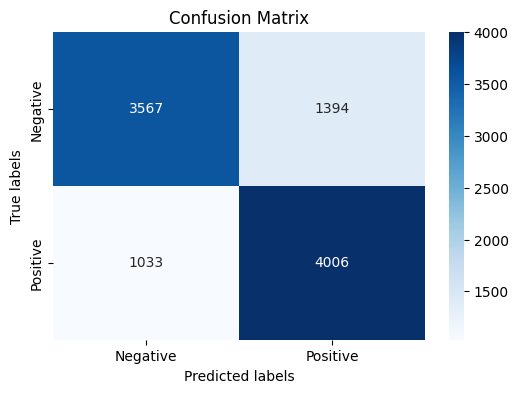

In [82]:
def plot_confusion_matrix(conf_matrix, labels):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(conf_matrix_nn, ['Negative', 'Positive'])

####Precision-Recall Curve

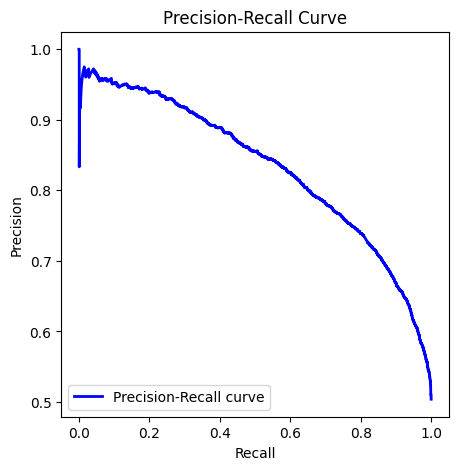

In [83]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_nn, pos_label=1)
plt.figure(figsize=(5, 5))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

####ROC Curve

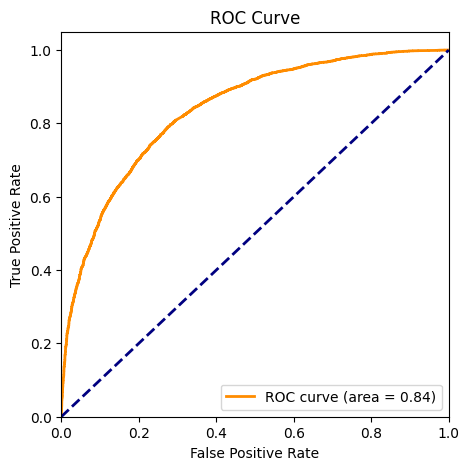

In [84]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_nn, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

####Learning Curve

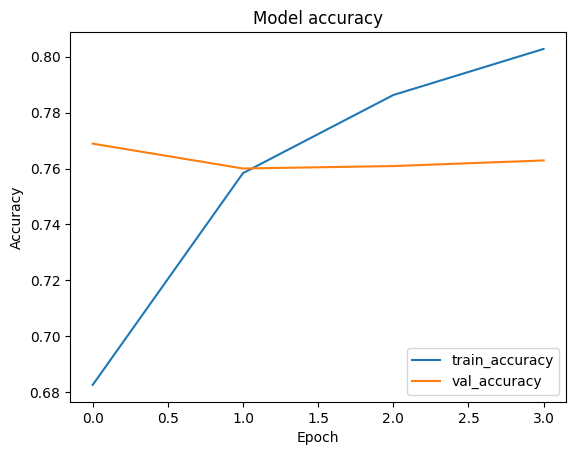

In [85]:
plt.plot(best_model_nn_history.history['accuracy'], label='train_accuracy')
plt.plot(best_model_nn_history.history['val_accuracy'], label='val_accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

####Validation Curve

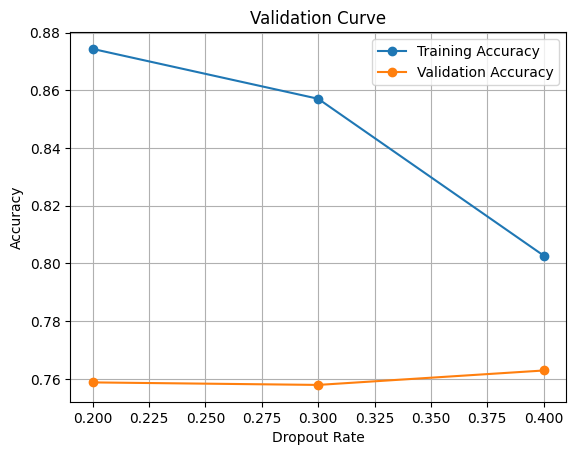

In [86]:
dropout_rates = param_grid['dropout_rate']
def plot_validation_curve(dropout_rates, train_scores, val_scores):
    plt.plot(dropout_rates, train_scores, marker='o', label='Training Accuracy')
    plt.plot(dropout_rates, val_scores, marker='o', label='Validation Accuracy')
    plt.title('Validation Curve')
    plt.xlabel('Dropout Rate')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_validation_curve(dropout_rates, train_scores, val_scores)

##Convolution Neural Network

###Implementation and Training

In [41]:
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4]
}

In [ ]:
train_scores = []
val_scores = []

In [42]:
def create_cnn_model(embedding_matrix, maxlen, embedding_dim=100, max_words=10000, dropout_rate=0.2):
    model = Sequential()
    model.add(Embedding(embedding_matrix.shape[0],
                        embedding_matrix.shape[1],
                        input_length=maxlen,
                        weights=[embedding_matrix],
                        trainable=False))
    model.add(Conv1D(32, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Conv1D(32, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [43]:
best_val_acc_cnn = 0
best_model_cnn = None
best_hyperparams_cnn = None
best_model_cnn_history = None

In [54]:
train_scores = []
val_scores = []

for dropout_rate in param_grid['dropout_rate']:
    model = create_cnn_model(embedding_matrix=embedding_matrix, maxlen=maxlen, embedding_dim=embedding_dim, max_words=max_words, dropout_rate=dropout_rate)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)
    history = model.fit(X_train_pad, y_train, epochs=10, batch_size=32, verbose=1,
              validation_data=(X_val_pad, y_val), callbacks=[early_stopping])
    val_loss, val_acc = model.evaluate(X_val_pad, y_val)
    train_acc = history.history['accuracy'][-1]
    train_scores.append(train_acc)
    val_scores.append(val_acc)
    print("Dropout Rate:", dropout_rate)
    print("Training Accuracy:", train_acc)
    print("Validation Accuracy:", val_acc)
    if val_acc > best_val_acc_cnn:
        best_val_acc_cnn = val_acc
        best_model_cnn = model
        best_model_cnn_history = history
        best_hyperparams_cnn = {'dropout_rate': dropout_rate}


Epoch 1/10
1000/1000 [==============================] - 20s 18ms/step - loss: 0.4772 - accuracy: 0.7663 - val_loss: 0.3919 - val_accuracy: 0.8240
Epoch 2/10
1000/1000 [==============================] - 18s 18ms/step - loss: 0.3856 - accuracy: 0.8266 - val_loss: 0.3711 - val_accuracy: 0.8325
Epoch 3/10
1000/1000 [==============================] - 19s 19ms/step - loss: 0.3468 - accuracy: 0.8472 - val_loss: 0.3655 - val_accuracy: 0.8378
Epoch 4/10
1000/1000 [==============================] - 17s 17ms/step - loss: 0.3156 - accuracy: 0.8639 - val_loss: 0.3706 - val_accuracy: 0.8341
Epoch 5/10
1000/1000 [==============================] - 17s 17ms/step - loss: 0.2831 - accuracy: 0.8801 - val_loss: 0.3752 - val_accuracy: 0.8350
Epoch 6/10
250/250 [==============================] - 1s 5ms/step - loss: 0.4127 - accuracy: 0.8227
Dropout Rate: 0.2
Training Accuracy: 0.8957812786102295
Validation Accuracy: 0.8227499723434448
Epoch 1/10
1000/1000 [==============================] - 18s 17ms/step - lo

###Performance Metrics

In [45]:
test_loss_cnn, test_acc_cnn = best_model_cnn.evaluate(X_test_pad, y_test)
y_pred_proba_cnn = best_model_cnn.predict(X_test_pad)
y_pred_cnn = (y_pred_proba_cnn > 0.5).astype("int32")
conf_matrix_cnn = confusion_matrix(y_test, y_pred_cnn)
class_report_cnn = classification_report(y_test, y_pred_cnn)
logloss_cnn = log_loss(y_test, y_pred_proba_cnn)
mcc_cnn = matthews_corrcoef(y_test, y_pred_cnn)

313/313 [==============================] - 4s 11ms/step


In [46]:
print("Best Hyperparameters of CNN:", best_hyperparams_cnn)
print("Best Training Accuracy:", best_val_acc_cnn)
print("Testing Accuracy with best CNN model:", test_acc_cnn)
print("Log Loss of CNN :", logloss_cnn)
print("Matthews Correlation Coefficient of CNN:", mcc_cnn)
print("Best Model CNN Summary:")
print(best_model_cnn.summary())

Best Hyperparameters of CNN: {'dropout_rate': 0.3}
Best Training Accuracy: 0.8381249904632568
Testing Accuracy with best CNN model: 0.828499972820282
Log Loss of CNN : 0.3868930714206008
Matthews Correlation Coefficient of CNN: 0.6572566808865304
Best Model CNN Summary:
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 conv1d_10 (Conv1D)          (None, 96, 32)            16032     
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 19, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 15, 32)            5152      
                                               

In [47]:
print("Classification Report of CNN:")
print(class_report_cnn)

Classification Report of CNN:
              precision    recall  f1-score   support

           0       0.84      0.81      0.82      4961
           1       0.82      0.85      0.83      5039

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



###Performance representations and Curves

####Confusion Matrix

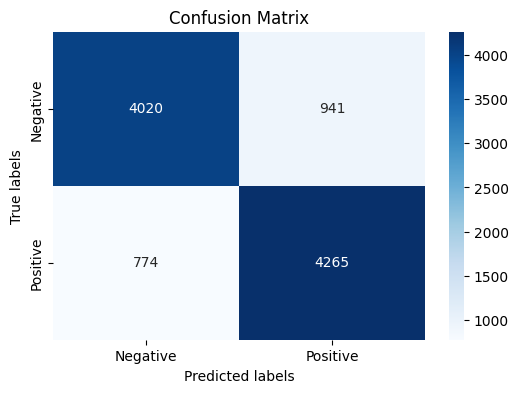

In [48]:
def plot_confusion_matrix(conf_matrix, labels):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(conf_matrix_cnn, ['Negative', 'Positive'])

####Precision-Recall Curve

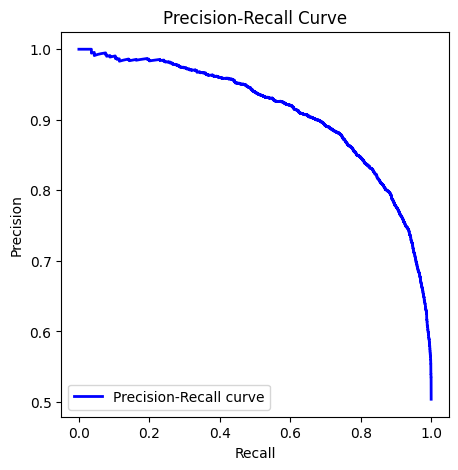

In [49]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_cnn, pos_label=1)
plt.figure(figsize=(5, 5))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

####ROC Curve

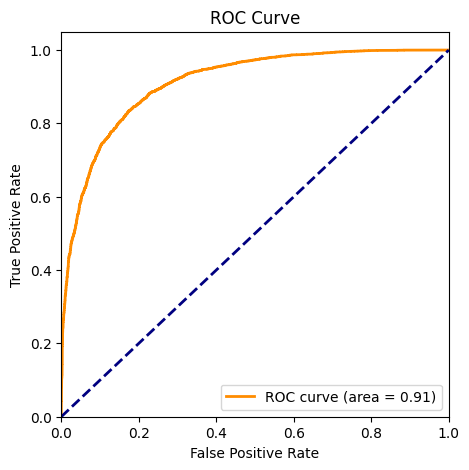

In [50]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_cnn, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

####Learning Curve

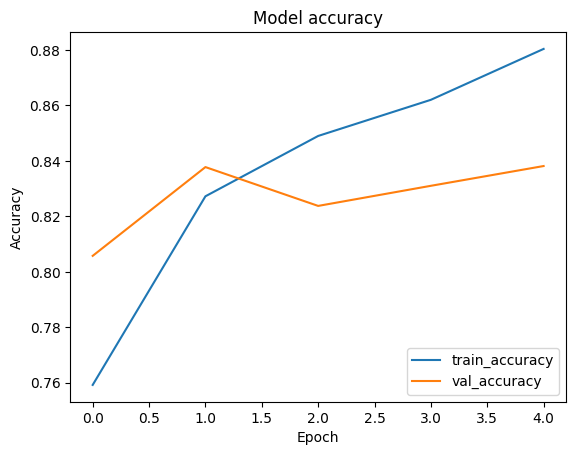

In [52]:
plt.plot(best_model_cnn_history.history['accuracy'], label='train_accuracy')
plt.plot(best_model_cnn_history.history['val_accuracy'], label='val_accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

####Validation Curve

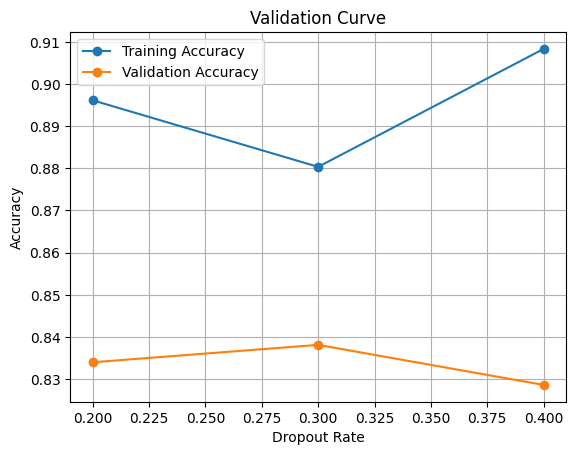

In [53]:
dropout_rates = param_grid['dropout_rate']
def plot_validation_curve(dropout_rates, train_scores, val_scores):
    plt.plot(dropout_rates, train_scores, marker='o', label='Training Accuracy')
    plt.plot(dropout_rates, val_scores, marker='o', label='Validation Accuracy')
    plt.title('Validation Curve')
    plt.xlabel('Dropout Rate')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_validation_curve(dropout_rates, train_scores, val_scores)

##LSTM

###Implementation and Training

In [87]:
param_grid_lstm = {
    'dropout_rate': [0.2, 0.3, 0.4]
}

In [88]:
def create_lstm_model(embedding_matrix, maxlen, embedding_dim=100, max_words=10000, dropout_rate=0.2):
    model = Sequential()
    model.add(Embedding(embedding_matrix.shape[0],
                        embedding_matrix.shape[1],
                        input_length=maxlen,
                        weights=[embedding_matrix],
                        trainable=False))
    model.add(LSTM(32))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [89]:
best_val_acc_lstm = 0
best_model_lstm = None
best_model_lstm_history = history
best_hyperparams_lstm = None

In [91]:
train_scores = []
val_scores = []

In [92]:
for dropout_rate in param_grid['dropout_rate']:
    model = create_lstm_model(embedding_matrix=embedding_matrix, maxlen=maxlen, embedding_dim=embedding_dim, max_words=max_words, dropout_rate=dropout_rate)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)
    history = model.fit(X_train_pad, y_train, epochs=10, batch_size=32, verbose=1,
              validation_data=(X_val_pad, y_val), callbacks=[early_stopping])
    val_loss, val_acc = model.evaluate(X_val_pad, y_val)
    train_acc = history.history['accuracy'][-1]
    train_scores.append(train_acc)
    val_scores.append(val_acc)
    if val_acc > best_val_acc_lstm:
        best_val_acc_lstm = val_acc
        best_model_lstm = model
        best_model_lstm_history = history
        best_hyperparams_lstm = {'dropout_rate': dropout_rate}

Epoch 1/10
1000/1000 [==============================] - 47s 42ms/step - loss: 0.4686 - accuracy: 0.7752 - val_loss: 0.3750 - val_accuracy: 0.8381
Epoch 2/10
1000/1000 [==============================] - 42s 42ms/step - loss: 0.3693 - accuracy: 0.8345 - val_loss: 0.3373 - val_accuracy: 0.8566
Epoch 3/10
1000/1000 [==============================] - 41s 41ms/step - loss: 0.3358 - accuracy: 0.8522 - val_loss: 0.3245 - val_accuracy: 0.8574
Epoch 4/10
1000/1000 [==============================] - 40s 40ms/step - loss: 0.3162 - accuracy: 0.8649 - val_loss: 0.3224 - val_accuracy: 0.8611
Epoch 5/10
1000/1000 [==============================] - 44s 44ms/step - loss: 0.2990 - accuracy: 0.8733 - val_loss: 0.3124 - val_accuracy: 0.8695
Epoch 6/10
1000/1000 [==============================] - 42s 42ms/step - loss: 0.2846 - accuracy: 0.8808 - val_loss: 0.3082 - val_accuracy: 0.8685
Epoch 7/10
1000/1000 [==============================] - 41s 41ms/step - loss: 0.2678 - accuracy: 0.8875 - val_loss: 0.3307 -

###Performance Metrics

In [93]:
test_loss_lstm, test_acc_lstm = best_model_lstm.evaluate(X_test_pad, y_test)
y_pred_proba_lstm = best_model_lstm.predict(X_test_pad)
y_pred_lstm = (y_pred_proba_lstm > 0.5).astype("int32")
conf_matrix_lstm = confusion_matrix(y_test, y_pred_lstm)
class_report_lstm = classification_report(y_test, y_pred_lstm)
logloss_lstm = log_loss(y_test, y_pred_proba_lstm)
mcc_lstm = matthews_corrcoef(y_test, y_pred_lstm)

313/313 [==============================] - 4s 13ms/step


In [94]:
print("Best Hyperparameters of LSTM:", best_hyperparams_lstm)
print("Best Training Accuracy:", best_val_acc_lstm)
print("Testing Accuracy with best LSTM model:", test_acc_lstm)
print("Log Loss of LSTM :", logloss_lstm)
print("Matthews Correlation Coefficient of LSTM:", mcc_lstm)
print("Best Model LSTM Summary:")
print(best_model_lstm.summary())

Best Hyperparameters of LSTM: {'dropout_rate': 0.3}
Best Training Accuracy: 0.8727499842643738
Testing Accuracy with best LSTM model: 0.8641999959945679
Log Loss of LSTM : 0.32926201476515987
Matthews Correlation Coefficient of LSTM: 0.7286402047765063
Best Model LSTM Summary:
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 100, 100)          1000000   
                                                                 
 lstm_2 (LSTM)               (None, 32)                17024     
                                                                 
 dense_30 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1017057 (3.88 MB)
Trainable params: 17057 (66.63 KB)
Non-trainable params: 1000000 (3.81 MB)
________________________________________________________________

In [95]:
print("Classification Report of LSTM:")
print(class_report_lstm)

Classification Report of LSTM:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      4961
           1       0.85      0.88      0.87      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



###Performance representations and Curves

####Confusion Matrix

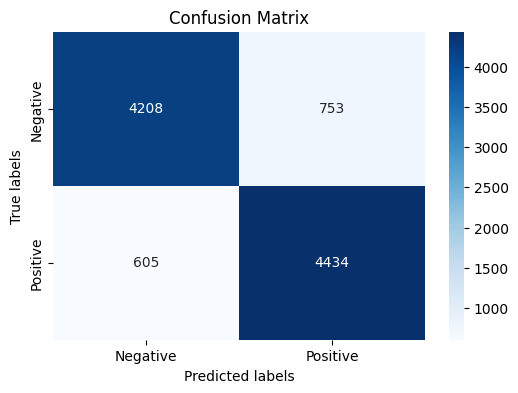

In [96]:
def plot_confusion_matrix(conf_matrix, labels):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(conf_matrix_lstm, ['Negative', 'Positive'])

####Precision-Recall Curve

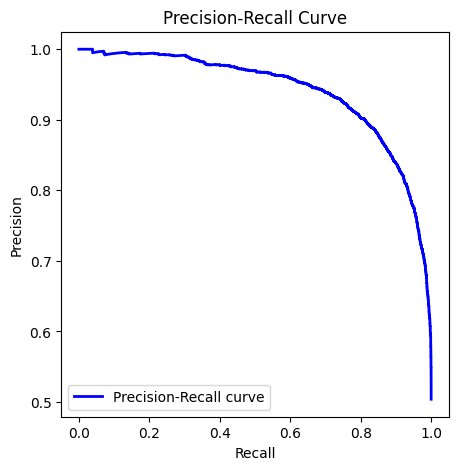

In [97]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_lstm, pos_label=1)
plt.figure(figsize=(5, 5))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

####ROC Curve

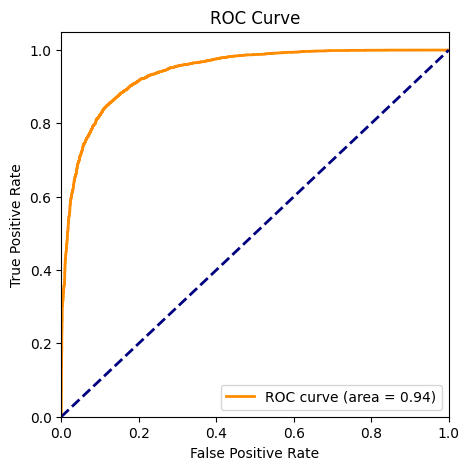

In [98]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_lstm, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

####Learning Curve

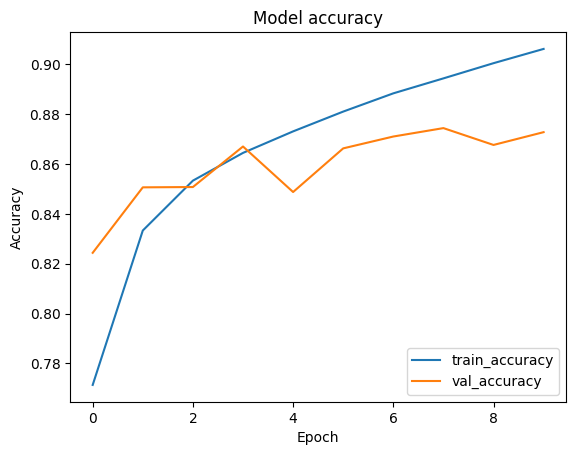

In [99]:
plt.plot(best_model_lstm_history.history['accuracy'], label='train_accuracy')
plt.plot(best_model_lstm_history.history['val_accuracy'], label='val_accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

####Validation Curve

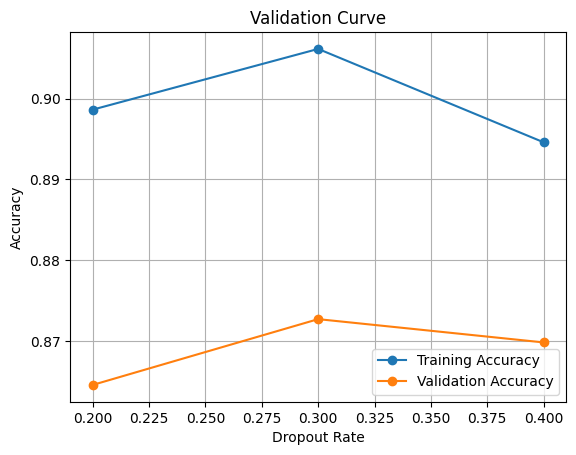

In [100]:
def plot_validation_curve(dropout_rates, train_scores, val_scores):
    plt.plot(dropout_rates, train_scores, marker='o', label='Training Accuracy')
    plt.plot(dropout_rates, val_scores, marker='o', label='Validation Accuracy')
    plt.title('Validation Curve')
    plt.xlabel('Dropout Rate')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_validation_curve(dropout_rates, train_scores, val_scores)